# Naive RNN Forecast on Financial Data

### Description
This file is intended to demonstrate a simple and believably inaccurate version of RNN forecast on financial data. The data passed into the RNN model will only involve simple feature engineering.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### Read Data

In [2]:
# Data downloaded from investing.com and transformed by 
df = pd.read_csv('HSI Futures.csv', index_col='Date')

In [3]:
df

,Close,Open,High,Low
Date,,,,
2009-11-19,22537,22752,22853,22537
2009-11-20,22408,22543,22599,22357
2009-11-23,22772,22514,22805,22486
2009-11-24,22476,22785,22819,22263
2009-11-25,22606,22462,22680,22356
...,...,...,...,...
2020-08-17,25293,25052,25574,25014
2020-08-18,25341,25330,25440,25213
2020-08-19,25135,25349,25395,25041


## Method 1: Only Return Data
Use previous returns to predict the direction.

In [4]:
df1 = df.copy()

In [5]:
df1['return'] = (df1['Close'] / df1.shift(1)['Close']) - 1

In [6]:
df1['target'] = np.sign(df1['return']).apply(lambda x: 0 if x == -1.0 else x)

In [7]:
df1.dropna(inplace=True)
df1.drop(['Close', 'Open', 'High', 'Low'], axis=1, inplace=True)

### Define features and target

In [8]:
df1x = df1['return']
df1y = df1['target']

In [9]:
T = 20
D = 1
N = len(df1) - T
split = N // 3 * 2

X = []
Y = []

for t in range(N):
    X.append(df1x.iloc[t:t+T])
    Y.append(df1y.iloc[t+T])
    
X = np.array(X).reshape(N, T, D)
Y = np.array(Y)

### SimpleRNN

In [22]:
model1_simple = Sequential([
    Input((T, D)),
    SimpleRNN(5),
    Dense(1, activation='relu')
])

model1_simple.compile(optimizer=Adam(lr=0.01), loss='mse', metrics=['MeanAbsoluteError'])

In [23]:
r1_simple = model1_simple.fit(X[:split], Y[:split], epochs=100, batch_size=25, validation_data=(X[split:], Y[split:]))

Train on 1752 samples, validate on 876 samples
Epoch 1/100
1752/1752 [==============================] - 5s 3ms/sample - loss: 0.2699 - MeanAbsoluteError: 0.5054 - val_loss: 0.2490 - val_MeanAbsoluteError: 0.4979
Epoch 2/100
1752/1752 [==============================] - 1s 481us/sample - loss: 0.2510 - MeanAbsoluteError: 0.4991 - val_loss: 0.2501 - val_MeanAbsoluteError: 0.4948
Epoch 3/100
1752/1752 [==============================] - 1s 508us/sample - loss: 0.2529 - MeanAbsoluteError: 0.4997 - val_loss: 0.2498 - val_MeanAbsoluteError: 0.4994
Epoch 4/100
1752/1752 [==============================] - 1s 539us/sample - loss: 0.2497 - MeanAbsoluteError: 0.4968 - val_loss: 0.2493 - val_MeanAbsoluteError: 0.4984
Epoch 5/100
1752/1752 [==============================] - 1s 457us/sample - loss: 0.2539 - MeanAbsoluteError: 0.5003 - val_loss: 0.2492 - val_MeanAbsoluteError: 0.4986
Epoch 6/100
1752/1752 [==============================] - 1s 471us/sample - loss: 0.2498 - MeanAbsoluteError: 0.4980 - va

1752/1752 [==============================] - 1s 525us/sample - loss: 0.2499 - MeanAbsoluteError: 0.4983 - val_loss: 0.2488 - val_MeanAbsoluteError: 0.4973
Epoch 50/100
1752/1752 [==============================] - 1s 473us/sample - loss: 0.2502 - MeanAbsoluteError: 0.4990 - val_loss: 0.2492 - val_MeanAbsoluteError: 0.4963
Epoch 51/100
1752/1752 [==============================] - 1s 504us/sample - loss: 0.2505 - MeanAbsoluteError: 0.4988 - val_loss: 0.2489 - val_MeanAbsoluteError: 0.4985
Epoch 52/100
1752/1752 [==============================] - 1s 526us/sample - loss: 0.2509 - MeanAbsoluteError: 0.4999 - val_loss: 0.2494 - val_MeanAbsoluteError: 0.4993
Epoch 53/100
1752/1752 [==============================] - 1s 447us/sample - loss: 0.2498 - MeanAbsoluteError: 0.4994 - val_loss: 0.2490 - val_MeanAbsoluteError: 0.4967
Epoch 54/100
1752/1752 [==============================] - 1s 500us/sample - loss: 0.2500 - MeanAbsoluteError: 0.4992 - val_loss: 0.2490 - val_MeanAbsoluteError: 0.4986
Epoch

1752/1752 [==============================] - 1s 467us/sample - loss: 0.2500 - MeanAbsoluteError: 0.4994 - val_loss: 0.2489 - val_MeanAbsoluteError: 0.4981
Epoch 98/100
1752/1752 [==============================] - 1s 522us/sample - loss: 0.2499 - MeanAbsoluteError: 0.4994 - val_loss: 0.2496 - val_MeanAbsoluteError: 0.4996
Epoch 99/100
1752/1752 [==============================] - 1s 518us/sample - loss: 0.2500 - MeanAbsoluteError: 0.4998 - val_loss: 0.2491 - val_MeanAbsoluteError: 0.4967
Epoch 100/100
1752/1752 [==============================] - 1s 564us/sample - loss: 0.2500 - MeanAbsoluteError: 0.4990 - val_loss: 0.2489 - val_MeanAbsoluteError: 0.4982


(0.0, 1.0)

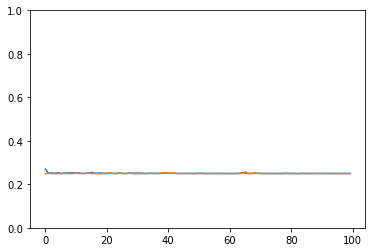

In [24]:
plt.plot(r1_simple.history['loss'], label='Loss')
plt.plot(r1_simple.history['val_loss'], label='Validation Loss')
plt.ylim(0, 1)

We can observe that there is not much pattern picked up by the RNN model. Let's use this "model" to forecast, imagining the situation where we have the true data of previous days and want to predict the next day:

In [34]:
pred1_simple = model1_simple.predict(X[split:])
pred1_simple

array([[0.52721554],
       [0.5272859 ],
       [0.52693033],
       [0.5266519 ],
       [0.5265541 ],
       [0.5267678 ],
       [0.5269357 ],
       [0.5269347 ],
       [0.52687484],
       [0.5266797 ],
       [0.526638  ],
       [0.52681196],
       [0.5269517 ],
       [0.527145  ],
       [0.52695143],
       [0.52678525],
       [0.52684706],
       [0.5270176 ],
       [0.52719766],
       [0.52707267],
       [0.5269706 ],
       [0.52694994],
       [0.52693266],
       [0.526839  ],
       [0.52672935],
       [0.5269646 ],
       [0.52710223],
       [0.5269043 ],
       [0.526709  ],
       [0.52673626],
       [0.5266126 ],
       [0.5266787 ],
       [0.52665865],
       [0.52682847],
       [0.52719283],
       [0.5271998 ],
       [0.52698445],
       [0.5268583 ],
       [0.52679217],
       [0.5268298 ],
       [0.5269384 ],
       [0.5270974 ],
       [0.52704746],
       [0.5268083 ],
       [0.5267437 ],
       [0.5268775 ],
       [0.52703273],
       [0.527

All predicts values situate around 0.52, i.e. if 0.5 is the decision threshold, this model will simply predict "buy" all the same. This is corresponding to the idea that financial indices are generally trending up.

### LSTM
If SimpleRNN does not work, would a more sophisticated LSTM succeed?

In [35]:
model1_lstm = Sequential([
    Input((T, D)),
    LSTM(5),
    Dense(1, activation='relu')
])

model1_lstm.compile(optimizer=Adam(lr=0.01), loss='mse', metrics=['MeanAbsoluteError'])

In [36]:
r1_lstm = model1_lstm.fit(X[:split], Y[:split], epochs=100, batch_size=25, validation_data=(X[split:], Y[split:]))

Train on 1752 samples, validate on 876 samples
Epoch 1/100
1752/1752 [==============================] - 5s 3ms/sample - loss: 0.2772 - MeanAbsoluteError: 0.5079 - val_loss: 0.2523 - val_MeanAbsoluteError: 0.4939
Epoch 2/100
1752/1752 [==============================] - 1s 675us/sample - loss: 0.2520 - MeanAbsoluteError: 0.4987 - val_loss: 0.2497 - val_MeanAbsoluteError: 0.4960
Epoch 3/100
1752/1752 [==============================] - 1s 723us/sample - loss: 0.2506 - MeanAbsoluteError: 0.4990 - val_loss: 0.2493 - val_MeanAbsoluteError: 0.4965
Epoch 4/100
1752/1752 [==============================] - 1s 720us/sample - loss: 0.2510 - MeanAbsoluteError: 0.4972 - val_loss: 0.2497 - val_MeanAbsoluteError: 0.4997
Epoch 5/100
1752/1752 [==============================] - 1s 801us/sample - loss: 0.2502 - MeanAbsoluteError: 0.4994 - val_loss: 0.2524 - val_MeanAbsoluteError: 0.4939
Epoch 6/100
1752/1752 [==============================] - 1s 750us/sample - loss: 0.2529 - MeanAbsoluteError: 0.5005 - va

1752/1752 [==============================] - 1s 797us/sample - loss: 0.2502 - MeanAbsoluteError: 0.4992 - val_loss: 0.2496 - val_MeanAbsoluteError: 0.4996
Epoch 50/100
1752/1752 [==============================] - 1s 754us/sample - loss: 0.2513 - MeanAbsoluteError: 0.4993 - val_loss: 0.2525 - val_MeanAbsoluteError: 0.5017
Epoch 51/100
1752/1752 [==============================] - 1s 693us/sample - loss: 0.2509 - MeanAbsoluteError: 0.5002 - val_loss: 0.2489 - val_MeanAbsoluteError: 0.4985
Epoch 52/100
1752/1752 [==============================] - 1s 749us/sample - loss: 0.2500 - MeanAbsoluteError: 0.4993 - val_loss: 0.2492 - val_MeanAbsoluteError: 0.4991
Epoch 53/100
1752/1752 [==============================] - 1s 726us/sample - loss: 0.2499 - MeanAbsoluteError: 0.4990 - val_loss: 0.2499 - val_MeanAbsoluteError: 0.4999
Epoch 54/100
1752/1752 [==============================] - 1s 639us/sample - loss: 0.2511 - MeanAbsoluteError: 0.5006 - val_loss: 0.2496 - val_MeanAbsoluteError: 0.4996
Epoch

1752/1752 [==============================] - 1s 604us/sample - loss: 0.2500 - MeanAbsoluteError: 0.4987 - val_loss: 0.2496 - val_MeanAbsoluteError: 0.4996
Epoch 98/100
1752/1752 [==============================] - 1s 601us/sample - loss: 0.2501 - MeanAbsoluteError: 0.4994 - val_loss: 0.2489 - val_MeanAbsoluteError: 0.4972
Epoch 99/100
1752/1752 [==============================] - 1s 587us/sample - loss: 0.2498 - MeanAbsoluteError: 0.4989 - val_loss: 0.2489 - val_MeanAbsoluteError: 0.4971
Epoch 100/100
1752/1752 [==============================] - 1s 573us/sample - loss: 0.2498 - MeanAbsoluteError: 0.4989 - val_loss: 0.2489 - val_MeanAbsoluteError: 0.4981


(0.0, 1.0)

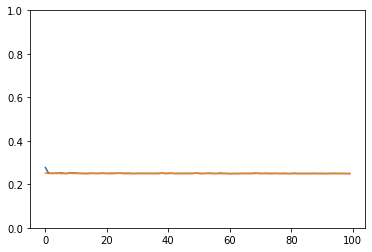

In [37]:
plt.plot(r1_lstm.history['loss'], label='Loss')
plt.plot(r1_lstm.history['val_loss'], label='Validation Loss')
plt.ylim(0, 1)

In [38]:
pred = model1_lstm.predict(X[split:])
pred

array([[0.5275071 ],
       [0.5274123 ],
       [0.52607775],
       [0.5265246 ],
       [0.5259811 ],
       [0.526478  ],
       [0.5262543 ],
       [0.5262312 ],
       [0.52642375],
       [0.52538097],
       [0.5259588 ],
       [0.52670443],
       [0.5262312 ],
       [0.5274781 ],
       [0.5260748 ],
       [0.526546  ],
       [0.5271838 ],
       [0.5271444 ],
       [0.52770543],
       [0.5268668 ],
       [0.52744746],
       [0.5273315 ],
       [0.52683145],
       [0.5264365 ],
       [0.5262204 ],
       [0.527705  ],
       [0.5267929 ],
       [0.52581763],
       [0.5265357 ],
       [0.5266637 ],
       [0.5245596 ],
       [0.52617407],
       [0.525541  ],
       [0.5260985 ],
       [0.5277357 ],
       [0.5268581 ],
       [0.5267273 ],
       [0.52724904],
       [0.5265186 ],
       [0.5265533 ],
       [0.5270576 ],
       [0.5275042 ],
       [0.52655965],
       [0.52611196],
       [0.5269772 ],
       [0.5268992 ],
       [0.526755  ],
       [0.527

No discernable difference with SimpleRNN. It is to conclude that this pure %change data does not work.

## Method 2: OHLC Data
OHLC stands for Open, High, Low and Close. In machine learning, regression prediction is a harder job compared to classification because of the difficulty to predict continuous value and to analyse the results, e.g. accuracy. Therefore, the target will be transformed into a daily return direction, namely positive (1) or negative (0).

In addition, in finance, the value of the index does not carry much prediction power per se. Thus the high, low and open data will be transformed into proportions to close.

One extra column on daily returns will be added.

In [89]:
df2 = df.copy()

In [90]:
df2['return'] = (df2['Close'] / df2.shift(1)['Close']) - 1

In [91]:
df2['target'] = np.sign(df2['return']).apply(lambda x: 0 if x == -1.0 else x)

In [92]:
for col in ['Open', 'High', 'Low']:
    df2[col] = df2[col] / df2['Close'] - 1

In [93]:
df2.dropna(inplace=True)
df2.drop('Close', axis=1, inplace=True)

In [94]:
df2

,Open,High,Low,return,target
Date,,,,,
2009-11-20,0.006025,0.008524,-0.002276,-0.005724,0.0
2009-11-23,-0.011330,0.001449,-0.012559,0.016244,1.0
2009-11-24,0.013748,0.015261,-0.009477,-0.012998,0.0
2009-11-25,-0.006370,0.003273,-0.011059,0.005784,1.0
2009-11-26,0.021425,0.021425,-0.003563,-0.019287,0.0
...,...,...,...,...,...
2020-08-17,-0.009528,0.011110,-0.011031,0.008734,1.0
2020-08-18,-0.000434,0.003907,-0.005051,0.001898,1.0
2020-08-19,0.008514,0.010344,-0.003740,-0.008129,0.0


### Define features and target

In [95]:
df2x = df2.drop('target', axis=1)
df2y = df2['target']

In [97]:
T = 20
D = 5
N = len(df2) - T

np.array(df2x.iloc[0:10])

array([[ 0.00602463,  0.00852374, -0.00227597, -0.00572392],
       [-0.0113297 ,  0.00144915, -0.01255928,  0.0162442 ],
       [ 0.013748  ,  0.01526072, -0.00947678, -0.01299842],
       [-0.00636999,  0.00327347, -0.01105901,  0.00578395],
       [ 0.02142535,  0.02142535, -0.00356337, -0.01928691],
       [ 0.0459564 ,  0.0459564 , -0.01104086, -0.04402346],
       [-0.00161053,  0.00924903, -0.00501565,  0.02538454],
       [-0.02564563,  0.        , -0.02564563,  0.02452604],
       [-0.00236512,  0.00205275, -0.00597974,  0.00646755],
       [-0.00492655,  0.00466025, -0.00772269,  0.00544424]])